<h2 style = 'color: orange'> ML - Real Estate - Portugal: </h2>

In [6]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
sns.set_theme(style="whitegrid")

<h3 style = 'color: orange'> Reading files:</h3>

In [7]:
df = pd.read_csv('porto_sell_1to6_bedrooms.csv')
df

,location,rooms,price,area,bathrooms,condition,ads_type,propriety_type,m2_price
0,"Cedofeita, Santo Ildefonso, Sé, Miragaia, São ...",4,390030.0,171.00,3,Unknown,Sell,House,2280.88
1,"Lordelo do Ouro e Massarelos, Porto",2,975000.0,160.40,2,Unknown,Sell,House,6078.55
2,"Lordelo do Ouro e Massarelos, Porto",5,325000.0,180.00,3,Unknown,Sell,House,1805.56
3,"Ramalde, Porto",4,1420000.0,271.00,3,Unknown,Sell,House,5239.85
4,"Cedofeita, Santo Ildefonso, Sé, Miragaia, São ...",1,253450.0,62.00,2,Unknown,Sell,House,4087.90
...,...,...,...,...,...,...,...,...,...
1053,"Aldoar, Foz do Douro e Nevogilde, Porto",5,760000.0,236.00,3,Unknown,Sell,House,3220.34
1054,"Aldoar, Foz do Douro e Nevogilde, Porto",4,1750000.0,214.80,3,Unknown,Sell,House,8147.11
1055,"Campanhã, Porto",1,159000.0,60.00,2,New,Sell,House,2650.00
1056,"Lordelo do Ouro e Massarelos, Porto",4,1350000.0,142.47,3,Unknown,Sell,House,9475.68


<h3 style = 'color: orange'> Data preprocessing:</h3>

In [8]:
df = df.drop('ads_type', axis= 1)

In [9]:
# Using pandas.get_dummies for one-hot encoding:

df_encoded = pd.get_dummies(df, columns=['location', 'condition', 'propriety_type'])

<h3 style = 'color: orange'> Modeling:</h3>

In [10]:
# Splitting the data into training (80%), validation (10%) and testing (10%) sets:

df_encoded_train, df_encoded_valid_test = train_test_split(df_encoded, test_size=0.2, random_state=54321)

df_encoded_valid, df_encoded_test = train_test_split(df_encoded_valid_test, test_size=0.5, random_state=54321)

In [11]:
# Declaring variables for 'features' and 'target':

train_features = df_encoded_train.drop(['price', 'm2_price'], axis=1)
train_target = df_encoded_train['price']

valid_features = df_encoded_valid.drop(['price', 'm2_price'], axis=1)
valid_target = df_encoded_valid['price']

test_features = df_encoded_test.drop(['price', 'm2_price'], axis=1)
test_target = df_encoded_test['price']

<h4 style = 'color: orange'>Linear Regression:</h4>

In [12]:
param_grid = {
    'fit_intercept': [True, False],       
}

model = LinearRegression()

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

grid_search.fit(train_features, train_target)

best_params = grid_search.best_params_
print("Best Parameters:", best_params)

predictions_valid = grid_search.predict(valid_features)
mse_valid = mean_squared_error(valid_target, predictions_valid)
print("RMSE:", np.sqrt(mse_valid))

Best Parameters: {'fit_intercept': True}
RMSE: 240661.1869035604


<h4 style = 'color: orange'>Random Forest Regressor with Grid Search CV:</h4>

In [16]:
# Defining hyperparameters:

param_grid = {
    'n_estimators': [50, 150, 300],  
    'max_depth': [10, 20, 30],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4],  
}

model = RandomForestRegressor(random_state=54321)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

grid_search.fit(train_features, train_target)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

best_model = RandomForestRegressor(**best_params, random_state=54321)
best_model.fit(train_features, train_target)

predictions_valid = best_model.predict(valid_features)

mse_valid = mean_squared_error(valid_target, predictions_valid)
print("RMSE:", np.sqrt(mse_valid))

Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}
RMSE: 208606.06987772472


<h4 style = 'color: orange'>CatBoost with Grid Search CV:</h4>

In [17]:
param_grid = {
    'n_estimators': [50, 100, 150],              
    'learning_rate': [0.01, 0.1, 0.2],           
    'depth': [5, 10, 15],                       
    'subsample': [0.8, 0.9, 1.0],               
    'min_data_in_leaf': [10, 20],              
    'colsample_bylevel': [0.8, 1.0]            
}

model = CatBoostRegressor(random_state=12345, silent=True)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

grid_search.fit(train_features, train_target)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

best_model = grid_search.best_estimator_

predictions_valid = best_model.predict(valid_features)
mse_valid = mean_squared_error(valid_target, predictions_valid)
print("RMSE:", np.sqrt(mse_valid))

Best Hyperparameters: {'colsample_bylevel': 0.8, 'depth': 5, 'learning_rate': 0.2, 'min_data_in_leaf': 10, 'n_estimators': 50, 'subsample': 0.9}
RMSE: 214956.93559536233


In [18]:
# Using test data in the model:

# Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}
# RMSE: 208606.06987772472

test_model = RandomForestRegressor(random_state=54321, max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=50)

test_model.fit(train_features, train_target)

predictions_test = test_model.predict(test_features)

mse_test = mean_squared_error(test_target, predictions_test)
print("RMSE:", np.sqrt(mse_test))

RMSE: 228124.5969108978


In [19]:
# DataFrame with the difference between the real price and the one predicted by the model:

test_df = pd.DataFrame({'predicted': predictions_test, 'real_price': test_target})

test_df['percentage_difference'] = np.sqrt((((test_df['predicted'] - test_df['real_price']) / test_df['real_price']) * 100)**2)

test_df.round(2)

,predicted,real_price,percentage_difference
532,310060.92,495000.0,37.36
731,801690.08,820000.0,2.23
1005,774738.87,600000.0,29.12
947,143522.76,139000.0,3.25
988,336666.54,550000.0,38.79
...,...,...,...
75,1089701.61,1475000.0,26.12
74,930601.13,1395000.0,33.29
971,1119124.06,1000000.0,11.91
606,1396199.97,1250000.0,11.70


In [20]:
test_df['percentage_difference'].describe()

count    106.000000
mean      30.050329
std       44.644219
min        0.022268
25%        5.210362
50%       15.366266
75%       37.150286
max      302.336107
Name: percentage_difference, dtype: float64

In [21]:
print(test_df['percentage_difference'].quantile([0.8, 0.85, 0.9, 0.95]))

0.80    47.428912
0.85    50.269208
0.90    67.931354
0.95    86.623559
Name: percentage_difference, dtype: float64


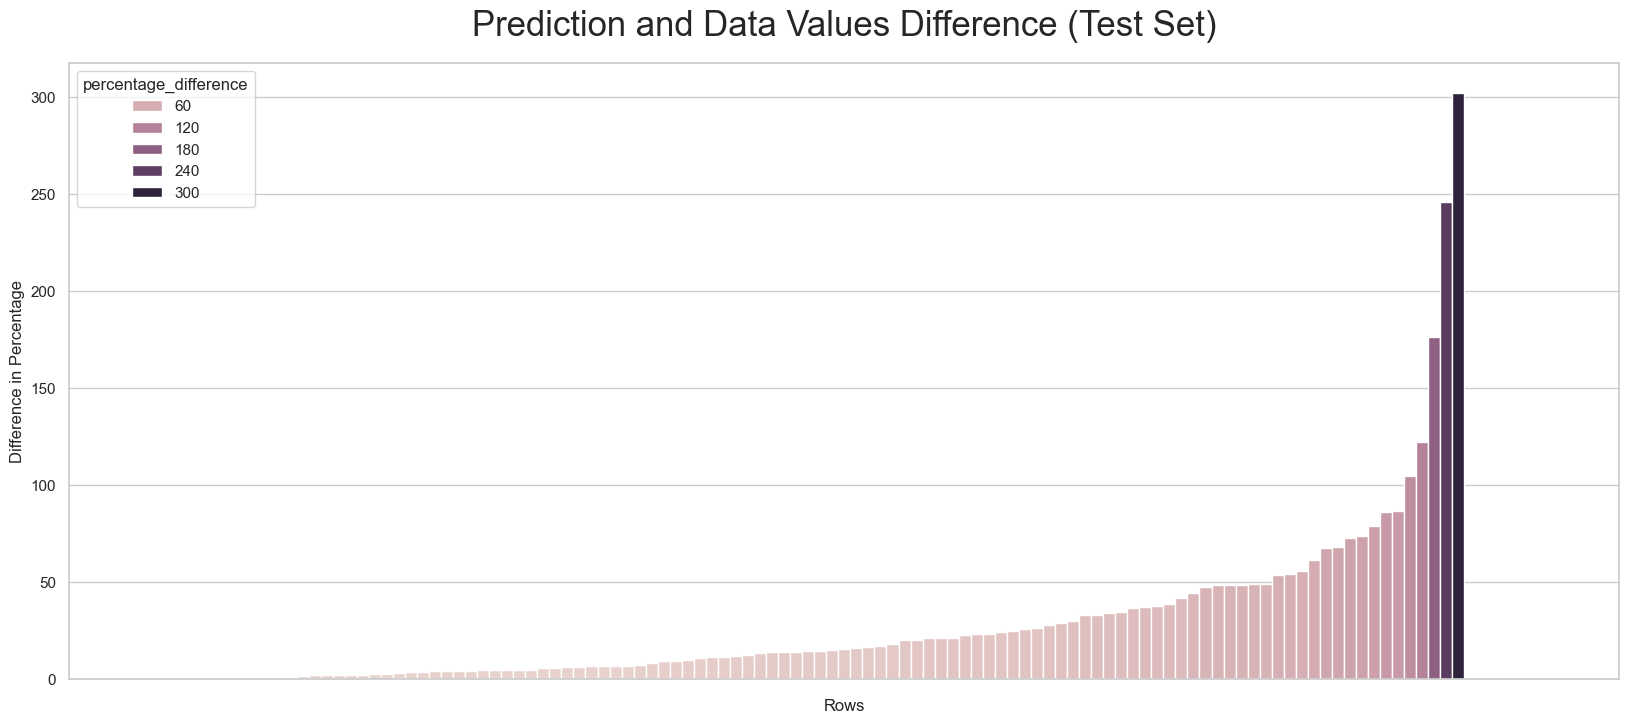

In [22]:
# Prediction and data values difference graph:

fig, (ax1) = plt.subplots(1, figsize=(20, 8));

sns.barplot(hue = 'percentage_difference',
             y = 'percentage_difference',
             data = test_df, ax = ax1);

ax1.set_title("Prediction and Data Values Difference (Test Set)", fontsize=25, pad=20);
ax1.set_xlabel("Rows");
ax1.set_ylabel("Difference in Percentage");
labels = [textwrap.fill(label.get_text(), width=30) for label in ax1.get_xticklabels()];
ax1.set_xticklabels(labels, rotation=90);

The model presents an average difference of less than 4% compared to the real data values.

At the 85th percentile, the difference is 5.9%. I consider it a good performance, considering that there are many properties with their asking price inconsistent with the real market value.